In [1]:
import pandas as pd
df = pd.read_csv('2_fraud_ex.csv')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

df_renamed = df[['type','amount','oldbalanceOrg', 'oldbalanceDest','newbalanceDest','isFraud']].copy()
df_X=df_renamed.drop(columns=['isFraud'])
df_y=df_renamed['isFraud']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, random_state=0, stratify=df_y)
smn = SMOTENC(random_state = 0, categorical_features = ['type'])
X_smn_train, y_smn_train = smn.fit_resample(X_train, y_train)
X_smn_train = pd.get_dummies(X_smn_train)
X_test = pd.get_dummies(X_test)

필요한 라이브러리를 로드하고 데이터 전처리를 수행합니다.
categorical 데이터가 포함된 불균형 데이터이므로 SMOTENC로 오버샘플링 합니다.
type feature는 원핫인코딩 해줍니다.

먼저 파라미터를 조정하지 않고 각 모델을 테스트해보겠습니다.
모델 평가를 위해 precision, recall, f1-score를 확인하고 ROC curve와 AUC를 모두 종합적으로 확인해보겠습니다.

In [2]:
forest = RandomForestClassifier(n_estimators=20, random_state=0)
forest.fit(X_smn_train, y_smn_train)

print("Training set accuracy: {:.3f}".format(forest.score(X_smn_train, y_smn_train)))
print("Test set accuracy: {:.3f}".format(forest.score(X_test, y_test)))

Training set accuracy: 1.000
Test set accuracy: 0.999


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.48      0.93      0.64      2053

    accuracy                           1.00   1590655
   macro avg       0.74      0.96      0.82   1590655
weighted avg       1.00      1.00      1.00   1590655



<function matplotlib.pyplot.show(close=None, block=None)>

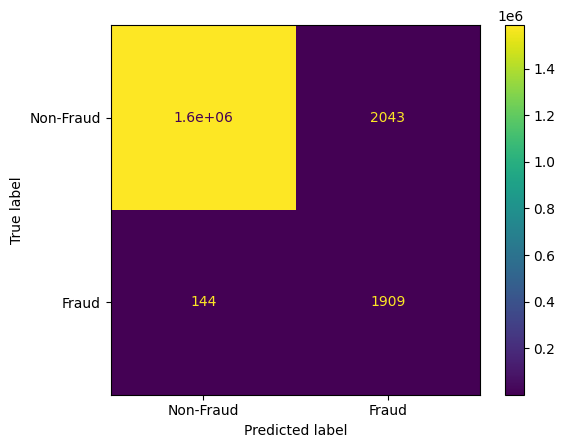

In [4]:
print(classification_report(y_test, forest.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
plt.show

AUC of RandomForest: 0.996


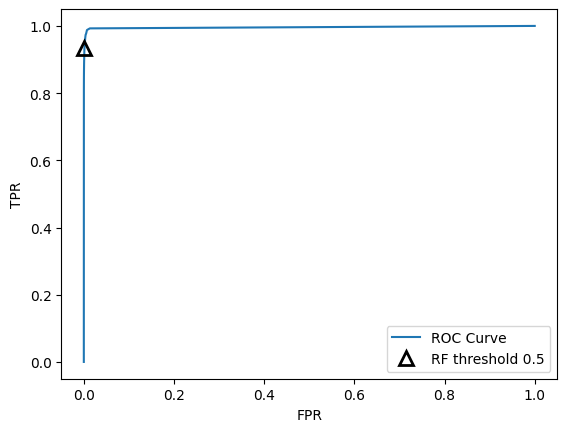

In [5]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import roc_auc_score

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, forest.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label="ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR")
close_default_rf = np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="RF threshold 0.5", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)
rf_auc = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
print("AUC of RandomForest: {:.3f}".format(rf_auc))

In [7]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(device='cuda')
xgb_model.fit(X_smn_train, y_smn_train)

print("Training set accuracy: {:.3f}".format(xgb_model.score(X_smn_train, y_smn_train)))
print("Test set accuracy: {:.3f}".format(xgb_model.score(X_test, y_test)))

Training set accuracy: 0.996
Test set accuracy: 0.995


              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1588602
           1       0.19      1.00      0.32      2053

    accuracy                           0.99   1590655
   macro avg       0.60      0.99      0.66   1590655
weighted avg       1.00      0.99      1.00   1590655



<function matplotlib.pyplot.show(close=None, block=None)>

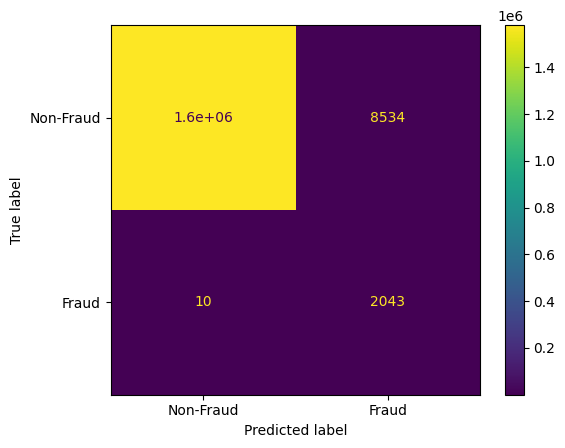

In [8]:
print(classification_report(y_test, xgb_model.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
plt.show

AUC of RandomForest: 0.999


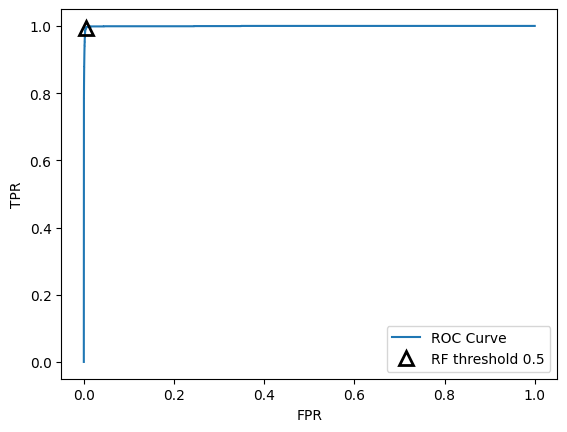

In [9]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label="ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR")
close_default_rf = np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="RF threshold 0.5", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)
rf_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
print("AUC of RandomForest: {:.3f}".format(rf_auc))

In [10]:
import lightgbm as lgb

gbm = lgb.LGBMClassifier()
gbm.fit(X_smn_train, y_smn_train)

print("Training set accuracy: {:.3f}".format(gbm.score(X_smn_train, y_smn_train)))
print("Test set accuracy: {:.3f}".format(gbm.score(X_test, y_test)))

[LightGBM] [Info] Number of positive: 4765805, number of negative: 4765805
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 9531610, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training set accuracy: 0.993
Test set accuracy: 0.988


              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1588602
           1       0.10      1.00      0.18      2053

    accuracy                           0.99   1590655
   macro avg       0.55      0.99      0.59   1590655
weighted avg       1.00      0.99      0.99   1590655



<function matplotlib.pyplot.show(close=None, block=None)>

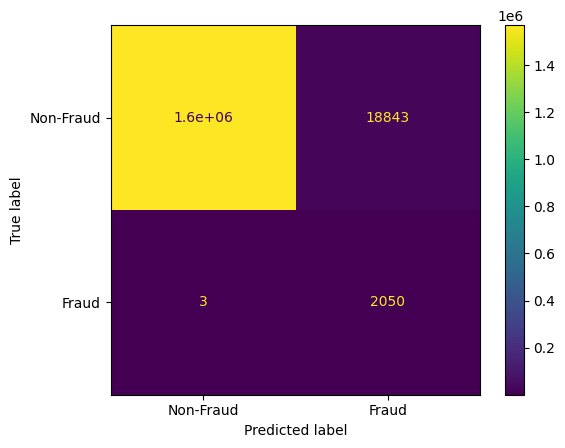

In [11]:
print(classification_report(y_test, gbm.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(gbm, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
plt.show

AUC of RandomForest: 0.999


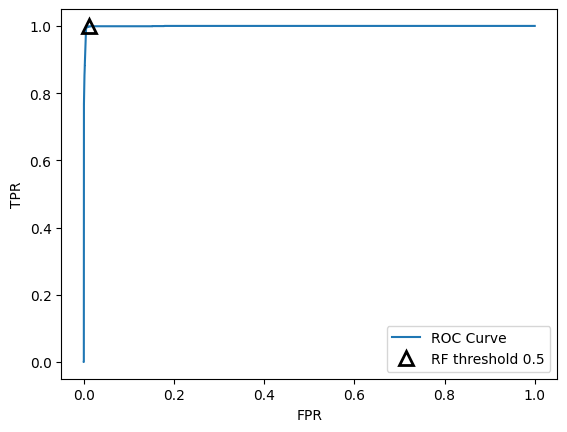

In [12]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, gbm.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label="ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR")
close_default_rf = np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="RF threshold 0.5", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)
rf_auc = roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1])
print("AUC of RandomForest: {:.3f}".format(rf_auc))

세개의 모델을 학습해본 결과 f1-score와 precision는 랜덤 포레스트가 가장 높았고, lightgbm의 경우 recall이 0.99로 사기 데이터에 대한 예측은 매우 정확하지만 정상 데이터를 사기 데이터로 예측하는 경우도 많았습니다. xgboost의 경우 사기 데이터에 대한 예측은 lightgbm보다는 떨어지지만 랜덤포레스트에 비해서는 매우 정확한 편이며 정상 데이터를 오인하는 경우는 lightgbm보다 적었습니다.
따라서 모델의 목표에 따라 lightgbm을 사용할 경우 사기 데이터는 정확하게 잡아내지만 정상 데이터를 사기 데이터로 오인하는 경우의 비용과
랜덤포레스트를 사용할 경우 사기 데이터를 정상 데이터로 판단하는 경우가 상당히 있어 이로 인한 비용을 고려했을때 xgboost를 사용하는 것이 사기 데이터는 대부분 잡아내면서도 정상 데이터에 대한 오인을 최소화 할 수 있다고 판단했습니다.
xgboost의 파라미터 튜닝을 통해 사기 데이터 검출 성능은 유지하면서 정상 데이터를 사기 데이터로 오인하는 경우를 줄여 성능을 향상시켜보겠습니다.

In [13]:
params = { 'booster' : ['gbtree','gblinear'],
          'eta' : [0.2, 0.3, 0.4],
          'max_depth' : [4, 6, 8],
          'colsample_bytree' : [0.8, 0.9, 1]
            }

In [14]:
xgb_model = xgb.XGBClassifier(n_estimators=100, device='cuda')
gridcv = GridSearchCV(xgb_model, param_grid = params,scoring = 'f1', cv = 3, n_jobs = -1)
gridcv.fit(X_smn_train, y_smn_train)
print(gridcv.best_params_)

{'booster': 'gbtree', 'colsample_bytree': 1, 'eta': 0.4, 'max_depth': 8}


Training set accuracy: 0.998
Test set accuracy: 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.32      0.99      0.48      2053

    accuracy                           1.00   1590655
   macro avg       0.66      0.99      0.74   1590655
weighted avg       1.00      1.00      1.00   1590655



<function matplotlib.pyplot.show(close=None, block=None)>

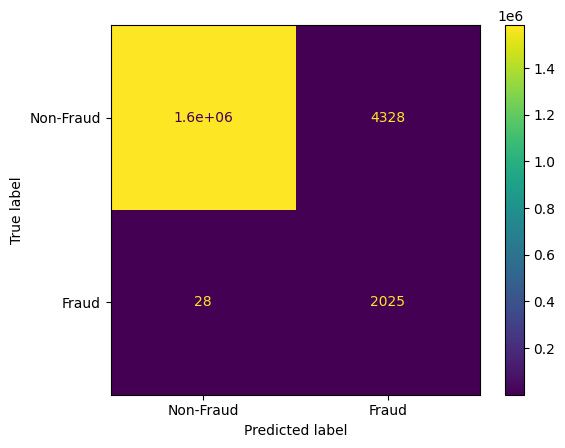

In [15]:
print("Training set accuracy: {:.3f}".format(gridcv.best_estimator_.score(X_smn_train, y_smn_train)))
print("Test set accuracy: {:.3f}".format(gridcv.best_estimator_.score(X_test, y_test)))
print(classification_report(y_test, gridcv.best_estimator_.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(gridcv.best_estimator_, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
plt.show

AUC of RandomForest: 0.999


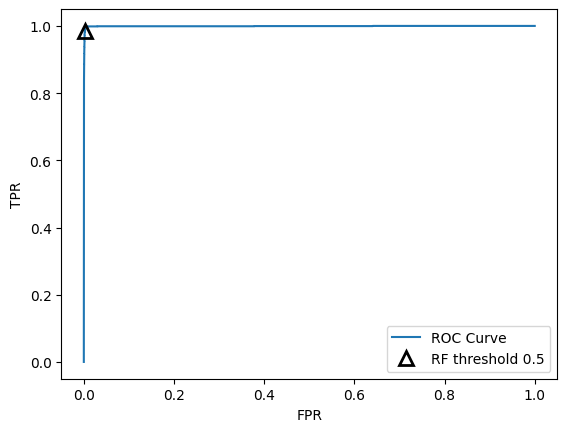

In [16]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, gridcv.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label="ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR")
close_default_rf = np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="RF threshold 0.5", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)
rf_auc = roc_auc_score(y_test, gridcv.best_estimator_.predict_proba(X_test)[:, 1])
print("AUC of RandomForest: {:.3f}".format(rf_auc))

실행 결과 'booster': 'gbtree', 'colsample_bytree': 1, 'eta': 0.4, 'max_depth': 8 일때 f1-score가 가장 높았습니다.
사기 데이터에 대한 예측률은 높게 유지하면서 정상 데이터를 오인하는 경우는 절반으로 줄었습니다.
lightgbm이나 랜덤포레스트 모델도 gridcv와 파라미터 튜닝으로 성능을 향상시켜보고 싶었지만 실행중 프로그램이 멈춰서 실행시간이 부족했습니다.